In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
url = '/content/drive/MyDrive/CSE4238/Offline 2/'

In [ ]:
dataset_A = url + 'Dataset A.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-a.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(19702, 2)


,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [ ]:
TRAIN_PATH = url + 'Train'

In [ ]:
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  19702


In [ ]:
np.random.seed(11)

# **Base Parameters**

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

20


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:789
Test dataloader:197


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.2966954708099365. Accuracy: 9.796954314720812
Epoch:  2
Iteration: 1000. Loss: 2.2998671531677246. Accuracy: 9.441624365482234
Iteration: 1500. Loss: 2.302687644958496. Accuracy: 9.416243654822335
Epoch:  3
Iteration: 2000. Loss: 2.302830934524536. Accuracy: 9.416243654822335
Epoch:  4
Iteration: 2500. Loss: 2.3040244579315186. Accuracy: 9.416243654822335
Iteration: 3000. Loss: 2.3008973598480225. Accuracy: 9.416243654822335
Epoch:  5
Iteration: 3500. Loss: 2.301185369491577. Accuracy: 9.796954314720812
Epoch:  6
Iteration: 4000. Loss: 2.3048508167266846. Accuracy: 9.416243654822335
Iteration: 4500. Loss: 2.3025825023651123. Accuracy: 9.796954314720812
Epoch:  7
Iteration: 5000. Loss: 2.3022825717926025. Accuracy: 10.558375634517766
Iteration: 5500. Loss: 2.3053207397460938. Accuracy: 9.416243654822335
Epoch:  8
Iteration: 6000. Loss: 2.298295259475708. Accuracy: 9.416243654822335
Epoch:  9
Iteration: 6500. Loss: 2.3074378967285156. Accuracy: 9.7969543

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/Offline 2/Models/model_base.pkl')

[2.2966954708099365, 2.2998671531677246, 2.302687644958496, 2.302830934524536, 2.3040244579315186, 2.3008973598480225, 2.301185369491577, 2.3048508167266846, 2.3025825023651123, 2.3022825717926025, 2.3053207397460938, 2.298295259475708, 2.3074378967285156, 2.3038766384124756, 2.298896551132202, 2.300086498260498, 2.306227922439575, 2.300537109375, 2.2955482006073, 2.2958195209503174, 2.2950778007507324, 2.273658037185669, 2.2702434062957764, 2.2396726608276367, 2.2202656269073486, 2.1418139934539795, 1.9776060581207275, 2.296581745147705, 1.9354232549667358, 1.9334173202514648, 2.0327365398406982]


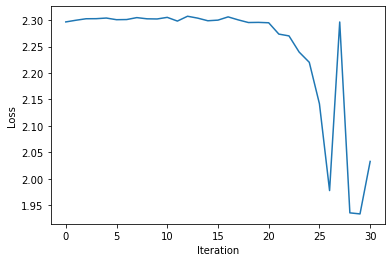

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **Tuned Parameters: 01**

In [ ]:
batch_size = 200
num_iters = 20000
input_dim = 28*28
num_hidden = 400
output_dim = 10

learning_rate = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

203


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:79
Test dataloader:20


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=400, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=400, out_features=400, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=400, out_features=400, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=400, out_features=400, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=400, out_features=400, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=400, out_features=400, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=400, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Iteration: 500. Loss: 2.299757480621338. Accuracy: 9.467005076142131
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Iteration: 1000. Loss: 2.2685282230377197. Accuracy: 14.01015228426396
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Iteration: 1500. Loss: 2.2112205028533936. Accuracy: 9.796954314720812
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 2000. Loss: 2.3060638904571533. Accuracy: 10.076142131979696
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Iteration: 2500. Loss: 2.1571779251098633. Accuracy: 19.873096446700508
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Iteration: 3000. Loss: 2.1697914600372314. Accuracy: 15.456852791878173
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Iteration: 3500. Loss: 2.298393964767456. Accuracy: 18.95939086294416
Epoch:  46
Epoch:

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/Offline 2/Models/model_1.pkl')

[2.299757480621338, 2.2685282230377197, 2.2112205028533936, 2.3060638904571533, 2.1571779251098633, 2.1697914600372314, 2.298393964767456, 2.0721054077148438, 2.084294557571411, 1.9608110189437866, 1.8520959615707397, 1.9763089418411255, 2.3350048065185547, 1.8245255947113037, 1.85410475730896, 2.2502949237823486, 1.6256568431854248, 1.6455230712890625, 1.6957179307937622, 2.300297498703003, 2.086353302001953, 1.2548532485961914, 1.7369967699050903, 1.2703708410263062, 1.3537015914916992, 1.7745147943496704, 1.0263112783432007, 0.9048941135406494, 1.0772883892059326, 0.8012681007385254, 1.1409642696380615, 0.9468228220939636]


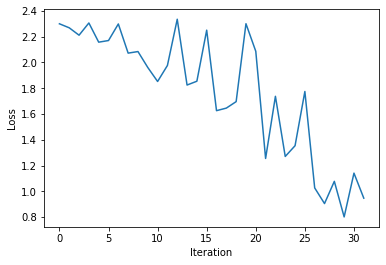

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **Tuned Parameters: 02**

In [ ]:
batch_size = 250
num_iters = 24000
input_dim = 28*28
num_hidden = 532
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

304


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:64
Test dataloader:16


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=532, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=532, out_features=532, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=532, out_features=532, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=532, out_features=532, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=532, out_features=532, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=532, out_features=532, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=532, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Iteration: 500. Loss: 2.302417516708374. Accuracy: 10.152284263959391
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 1000. Loss: 2.3020718097686768. Accuracy: 11.852791878172589
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 1500. Loss: 2.3030765056610107. Accuracy: 13.096446700507615
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Iteration: 2000. Loss: 2.3027470111846924. Accuracy: 9.593908629441625
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Iteration: 2500. Loss: 2.301628589630127. Accuracy: 9.593908629441625
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Iteration: 3000. Loss: 2.301098585128784. Accuracy: 9.593908629441625
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
E

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/Offline 2/Models/model_2.pkl')

[2.302417516708374, 2.3020718097686768, 2.3030765056610107, 2.3027470111846924, 2.301628589630127, 2.301098585128784, 2.301003932952881, 2.3009259700775146, 2.3027100563049316, 2.302433729171753, 2.3006064891815186, 2.2998604774475098, 2.29842209815979, 2.298219680786133, 2.2969324588775635, 2.300503730773926, 2.2940900325775146, 2.292847156524658, 2.2847673892974854, 2.2709269523620605, 2.2553486824035645, 2.196624279022217, 2.1967430114746094, 2.1292922496795654, 2.0971946716308594, 1.9804316759109497, 2.0514464378356934, 1.9430832862854004, 2.057790517807007, 2.0027382373809814, 2.033602714538574, 2.0060126781463623, 2.0668206214904785, 2.0471787452697754, 2.0606908798217773, 2.0732436180114746, 1.940060019493103, 1.8037245273590088]


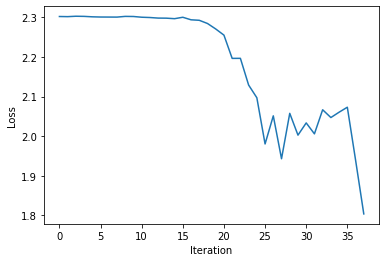

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **Tuned Parameters: 3**

In [ ]:
batch_size = 250
num_iters = 20000
input_dim = 28*28
num_hidden = 250
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

253


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:64
Test dataloader:16


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=250, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=250, out_features=250, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=250, out_features=250, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=250, out_features=250, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=250, out_features=250, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=250, out_features=250, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=250, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Iteration: 500. Loss: 1.8042632341384888. Accuracy: 22.741116751269036
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 1000. Loss: 1.6223139762878418. Accuracy: 26.243654822335024
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 1500. Loss: 1.6261943578720093. Accuracy: 33.2994923857868
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Iteration: 2000. Loss: 1.583701491355896. Accuracy: 30.0
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Iteration: 2500. Loss: 2.3370230197906494. Accuracy: 32.20812182741117
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Iteration: 3000. Loss: 1.5703938007354736. Accuracy: 41.598984771573605
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Ep

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/Offline 2/Models/model_3.pkl')

[1.8042632341384888, 1.6223139762878418, 1.6261943578720093, 1.583701491355896, 2.3370230197906494, 1.5703938007354736, 1.4682356119155884, 1.3488011360168457, 1.1392523050308228, 1.1950587034225464, 1.0444265604019165, 0.9833385944366455, 0.9505923390388489, 0.9016949534416199, 0.8886038661003113, 0.5298938155174255, 1.0093108415603638, 0.796596109867096, 0.8619968295097351, 0.7140133380889893, 0.7466236352920532, 0.6772938370704651, 0.7121106386184692, 0.8018173575401306, 0.9474112391471863, 0.7224571704864502, 0.643396258354187, 0.8429698348045349, 0.6157411336898804, 0.8173184990882874, 0.6643624305725098, 0.7484917640686035]


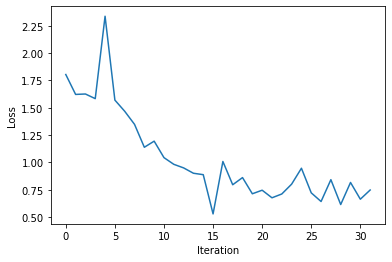

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **Tuned Parameters: 04**

In [ ]:
batch_size = 250
num_iters = 24000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

304


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:64
Test dataloader:16


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=220, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=220, out_features=220, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=220, out_features=220, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=220, out_features=220, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=220, out_features=220, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=220, out_features=220, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=220, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Iteration: 500. Loss: 1.8273845911026. Accuracy: 22.96954314720812
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 1000. Loss: 1.6754894256591797. Accuracy: 31.85279187817259
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 1500. Loss: 1.6052650213241577. Accuracy: 29.9746192893401
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Iteration: 2000. Loss: 1.5041186809539795. Accuracy: 30.609137055837564
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Iteration: 2500. Loss: 1.330026388168335. Accuracy: 37.38578680203046
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Iteration: 3000. Loss: 1.813132405281067. Accuracy: 59.16243654822335
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/Offline 2/Models/model_4.pkl')

[1.8273845911026, 1.6754894256591797, 1.6052650213241577, 1.5041186809539795, 1.330026388168335, 1.813132405281067, 1.0012925863265991, 0.858940601348877, 0.7729440927505493, 0.9309746026992798, 0.8078073263168335, 0.6990765929222107, 0.754106879234314, 0.8169974684715271, 0.6937756538391113, 0.637956440448761, 0.5517435073852539, 0.7173561453819275, 0.49648869037628174, 0.6509358882904053, 0.5318053960800171, 0.5389615893363953, 0.6128135919570923, 0.35490986704826355, 0.5787357687950134, 0.48564183712005615, 0.3249801695346832, 0.33546972274780273, 0.4564385414123535, 0.3548731505870819, 0.41263529658317566, 0.7040069103240967, 0.522861897945404, 0.41377973556518555, 0.45809856057167053, 0.6609698534011841, 0.352451354265213, 0.4854024648666382, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.

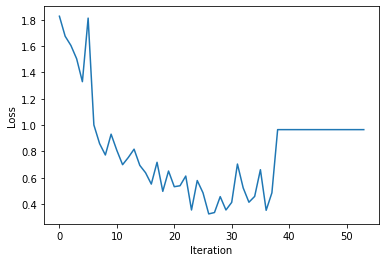

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [ ]:
iter = 19456
for epoch in range(19):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 19500. Loss: 0.4437919557094574. Accuracy: 84.06091370558376
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Iteration: 20000. Loss: 0.3088639974594116. Accuracy: 83.1472081218274
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Iteration: 20500. Loss: 0.3374162018299103. Accuracy: 83.42639593908629
Epoch:  18
Epoch:  19


[1.8273845911026, 1.6754894256591797, 1.6052650213241577, 1.5041186809539795, 1.330026388168335, 1.813132405281067, 1.0012925863265991, 0.858940601348877, 0.7729440927505493, 0.9309746026992798, 0.8078073263168335, 0.6990765929222107, 0.754106879234314, 0.8169974684715271, 0.6937756538391113, 0.637956440448761, 0.5517435073852539, 0.7173561453819275, 0.49648869037628174, 0.6509358882904053, 0.5318053960800171, 0.5389615893363953, 0.6128135919570923, 0.35490986704826355, 0.5787357687950134, 0.48564183712005615, 0.3249801695346832, 0.33546972274780273, 0.4564385414123535, 0.3548731505870819, 0.41263529658317566, 0.7040069103240967, 0.522861897945404, 0.41377973556518555, 0.45809856057167053, 0.6609698534011841, 0.352451354265213, 0.4854024648666382, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.

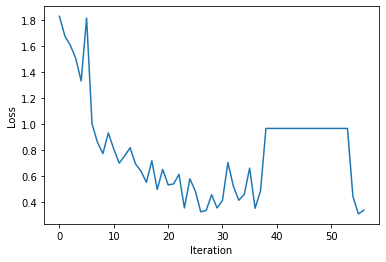

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [ ]:
print(iter)

20672


In [ ]:
iter = 20672
for epoch in range(6):
    print('Epoch: ', epoch + 1 + 323)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  324
Epoch:  325
Epoch:  326
Epoch:  327
Epoch:  328
Epoch:  329
Iteration: 21000. Loss: 0.3795692026615143. Accuracy: 86.16751269035532


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/Offline 2/Models/model_4F.pkl')

[1.8273845911026, 1.6754894256591797, 1.6052650213241577, 1.5041186809539795, 1.330026388168335, 1.813132405281067, 1.0012925863265991, 0.858940601348877, 0.7729440927505493, 0.9309746026992798, 0.8078073263168335, 0.6990765929222107, 0.754106879234314, 0.8169974684715271, 0.6937756538391113, 0.637956440448761, 0.5517435073852539, 0.7173561453819275, 0.49648869037628174, 0.6509358882904053, 0.5318053960800171, 0.5389615893363953, 0.6128135919570923, 0.35490986704826355, 0.5787357687950134, 0.48564183712005615, 0.3249801695346832, 0.33546972274780273, 0.4564385414123535, 0.3548731505870819, 0.41263529658317566, 0.7040069103240967, 0.522861897945404, 0.41377973556518555, 0.45809856057167053, 0.6609698534011841, 0.352451354265213, 0.4854024648666382, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.9655871391296387, 0.

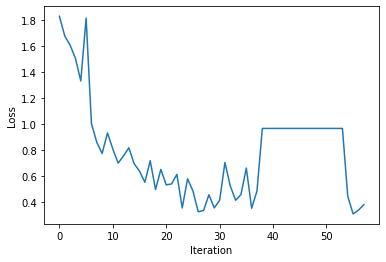

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **Summary**

In [3]:
from tabulate import tabulate

In [24]:
summary = {'Activation\nFunction':['ReLU', 'ReLU', 'ReLU', 'ReLU', 'ReLU'],
           'Optimizer':['SGD', 'SGD', 'SGD', 'ADAM', 'ADAM'],
           'Loss\nFunction':['Cross\nEntropy', 'Cross\nEntropy', 'Cross\nEntropy', 'Cross\nEntropy', 'Cross\nEntropy'],
           'Batch\nSize':[20, 200, 250, 250, 250],
           'Input':['28x28', '28x28', '28x28', '28x28', '28x28'],
           'Output':[10, 10, 10, 10, 10],
           'Hidden\nLayers':[6, 6, 6, 6, 6],
           'Hidden\nNodes':[200, 400, 532, 250, 220],
           'Epochs':[20, 203, 297, 250, 329],
           'Iterations':[15500, 16000, 19000, 16000, 21000],
           'LR':[0.01, 0.1, 0.01, 0.001, 0.001],
           'Loss':[2.03, 0.95, 1.80, 0.75, 0.38],
           'Accuracy':[11.65, 69.29, 30.35, 73.73, 86.17]}

table = pd.DataFrame(summary, index =['Base',
                                   'Test 01',
                                   'Test 02',
                                   'Test 03',
                                   'Test 04'])

In [25]:
print('COMPARISON TABLE:')
print(tabulate(table, headers = 'keys', tablefmt = 'fancy_grid'))

COMPARISON TABLE:
╒═════════╤══════════════╤═════════════╤════════════╤═════════╤═════════╤══════════╤══════════╤══════════╤══════════╤══════════════╤═══════╤════════╤════════════╕
│         │ Activation   │ Optimizer   │ Loss       │   Batch │ Input   │   Output │   Hidden │   Hidden │   Epochs │   Iterations │    LR │   Loss │   Accuracy │
│         │ Function     │             │ Function   │    Size │         │          │   Layers │    Nodes │          │              │       │        │            │
╞═════════╪══════════════╪═════════════╪════════════╪═════════╪═════════╪══════════╪══════════╪══════════╪══════════╪══════════════╪═══════╪════════╪════════════╡
│ Base    │ ReLU         │ SGD         │ Cross      │      20 │ 28x28   │       10 │        6 │      200 │       20 │        15500 │ 0.01  │   2.03 │      11.65 │
│         │              │             │ Entropy    │         │         │          │          │          │          │              │       │        │            │
├───